In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('framingham_clean.csv')
df.head()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Sex_male,currentSmoker_Yes,diabetes_Yes
0,39,4.0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,1,0,0
1,46,2.0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0,0,0
2,48,1.0,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,1,1,0
3,61,3.0,30.0,0.0,0,1,225.0,150.0,95.0,28.58,65.0,103.0,1,0,1,0
4,46,3.0,23.0,0.0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,1,0


In [3]:
df.TenYearCHD.value_counts()/len(df)*100

0    84.646739
1    15.353261
Name: TenYearCHD, dtype: float64

<AxesSubplot:>

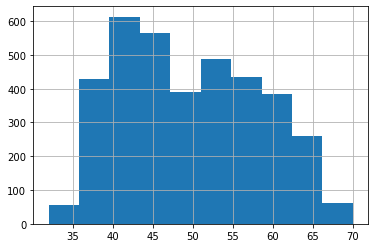

In [4]:
df.age.hist()

In [5]:
a = df.age.mean()
b = df.age.max()
c = df.age.min()

print('The mean age is :', a)
print('The oldest age is :', b)
print('The youngest age is :', c)

The mean age is : 49.566847826086956
The oldest age is : 70
The youngest age is : 32


## Estimating the Cost with cross validation

### Random Forest

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop('TenYearCHD', axis=1)
y = df.TenYearCHD

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [9]:
rf = RandomForestClassifier(n_estimators=50,
                            random_state=39,
                            max_depth=2,
                            n_jobs=4,
                            class_weight=None)

In [10]:
# set up parameter search grid
# including class weight

param_grid = {
  'n_estimators': [10, 50, 100],
  'max_depth': [None, 2, 3],
  'class_weight': [None, {0:1, 1:10}, {0:1, 1:100}],
}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=101)

In [12]:
search = GridSearchCV(estimator=rf,
                      scoring='roc_auc',
                      param_grid=param_grid,
                      cv=2,
                     ).fit(X_train, y_train)

In [13]:
search.best_score_

0.7122716338104416

In [14]:
search.best_params_

{'class_weight': None, 'max_depth': 3, 'n_estimators': 100}

In [15]:
search.best_estimator_

RandomForestClassifier(max_depth=3, n_jobs=4, random_state=39)

In [16]:
search.score(X_test, y_test)

0.7063635184224182

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [19]:
def run_logit(X_train, X_test, y_train, y_test, class_weight):
    logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        max_iter=100,
        n_jobs = 4,
        class_weight = class_weight)
    
    logit.fit(X_train, y_train)
    
    print('Train set')
    pred = logit.predict_proba(X_train)
    
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(X_test)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

#### Evaluate the performance of the algorithm with different costs

In [20]:
run_logit(X_train_std,
          X_test_std,
          y_train,
          y_test,
          class_weight=None)

Train set
Logistic Regression roc-auc: 0.7341107002608421
Test set
Logistic Regression roc-auc: 0.7413142189932537


In [21]:
run_logit(X_train_std,
          X_test_std,
          y_train,
          y_test,
          class_weight='balanced')

Train set
Logistic Regression roc-auc: 0.7346793934703472
Test set
Logistic Regression roc-auc: 0.7422742605085626


In [22]:
run_logit(X_train_std,
          X_test_std,
          y_train,
          y_test,
          class_weight={0:1, 1:10})

Train set
Logistic Regression roc-auc: 0.7344271505145183
Test set
Logistic Regression roc-auc: 0.742008303061754


## Smote NC

In [23]:
from imblearn.over_sampling import SMOTENC

In [24]:
X.head()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,sysBP,diaBP,BMI,heartRate,glucose,Sex_male,currentSmoker_Yes,diabetes_Yes
0,39,4.0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,1,0,0
1,46,2.0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0,0
2,48,1.0,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,1,1,0
3,61,3.0,30.0,0.0,0,1,225.0,150.0,95.0,28.58,65.0,103.0,0,1,0
4,46,3.0,23.0,0.0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,1,0


### Resample X and y

In [25]:
smnc = SMOTENC(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4,
    categorical_features=[1,3,4,5,12,13,14,] # indeces of the columns of categorical variables
)  

X_res, y_res = smnc.fit_resample(X, y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
X_res, y_res, test_size=0.3, random_state=101)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

### Scale numerical feats

In [28]:
# select numerical features for scaling
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('X_train',scaler,['cigsPerDay','totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate','glucose'])],remainder='passthrough')

scaled_X_train = ct.fit_transform(X_train)
scaled_X_test = ct.transform(X_test)

In [29]:
run_logit(scaled_X_train,
          scaled_X_test,
          y_train,
          y_test,
          class_weight=None)

Train set
Logistic Regression roc-auc: 0.7556855469735979
Test set
Logistic Regression roc-auc: 0.7769633507853404


In [30]:
run_logit(scaled_X_train,
          scaled_X_test,
          y_train,
          y_test,
          class_weight='balanced')

Train set
Logistic Regression roc-auc: 0.7556960640786174
Test set
Logistic Regression roc-auc: 0.7769633507853404


In [31]:
run_logit(scaled_X_train,
          scaled_X_test,
          y_train,
          y_test,
          class_weight={0:1, 1:10})

Train set
Logistic Regression roc-auc: 0.7530615292712066
Test set
Logistic Regression roc-auc: 0.7751165694776999


## Calibration

In [35]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

In [36]:
logit_cs = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    random_state=0,
    max_iter=10,
    n_jobs=4,
    class_weight='balanced',
).fit(scaled_X_train, y_train)

probs = logit_cs.predict_proba(scaled_X_test)[:, 1]
print('roc-auc of logit_cs', roc_auc_score(y_test, probs))
print('Brier Score of logit_cs', brier_score_loss(y_test, probs))
print()

roc-auc of logit_cs 0.7767410954666789
Brier Score of logit_cs 0.1925343536513906



In [37]:
def plot_calibration_curve(y_true, probs, bins, model):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy='uniform')
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label=type(model).__name__)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=False, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

In [39]:
import matplotlib.pyplot as plt

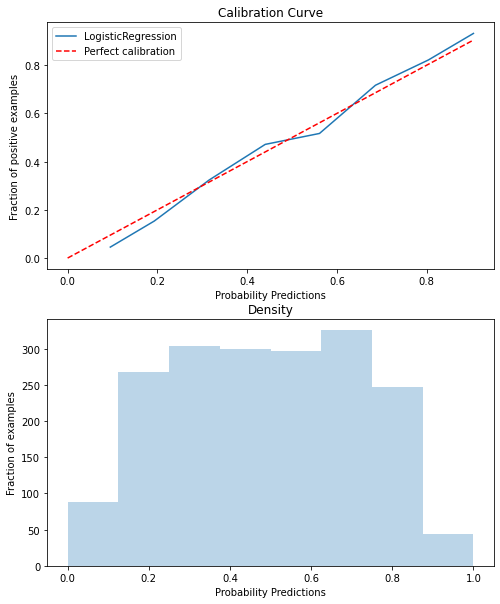

In [40]:
# Logistic Regression

model = logit_cs
probs = logit_cs.predict_proba(scaled_X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

## Isotonic Recalibration

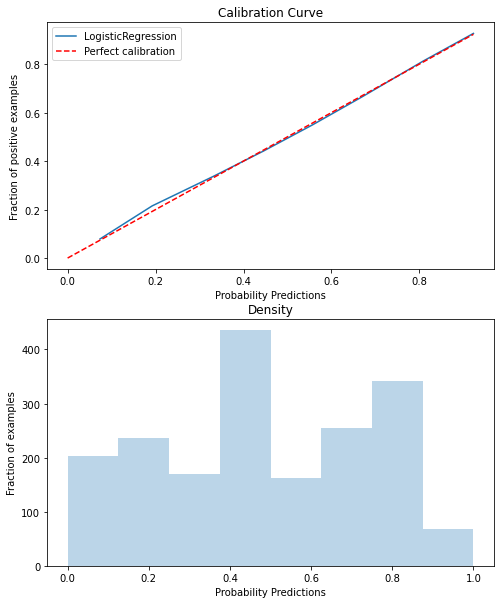

In [42]:
# Logistic Regression with cost sensitive learning
clf_isotonic = CalibratedClassifierCV(logit_cs, cv=5, method='isotonic')
clf_isotonic.fit(scaled_X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(scaled_X_test)[:, 1]

plot_calibration_curve(y_test, prob_isotonic, bins=8, model=model)